# Numba Intro

Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.

## Decorators



* @njit / @jit (nogil/parallel/fastmath/debug/inline)
* @cfunc
* @stencil
* @generated_jit
* @vectorize
* @gu_vectorize

More details : https://numba.pydata.org/numba-doc/dev/



## Hardware

In [1]:
import multiprocessing
import psutil
import torch

# CPU infos
print('Number of cpus {}'.format(multiprocessing.cpu_count()))
print('RAM available {:.1f} GB'.format(float(psutil.virtual_memory().available/pow(10,9))))

# GPU infos
devices = [d for d in range(torch.cuda.device_count())]
device_names = [torch.cuda.get_device_name(d) for d in devices]
print('Number of gpus {}'.format(len(devices)))
print('Gpu Names {}'.format(device_names))

Number of cpus 2
RAM available 12.5 GB
Number of gpus 1
Gpu Names ['Tesla K80']


## Stencil Code - Inpainting

We will use laplace inpainting to benchmark Numba

<Figure size 432x288 with 0 Axes>

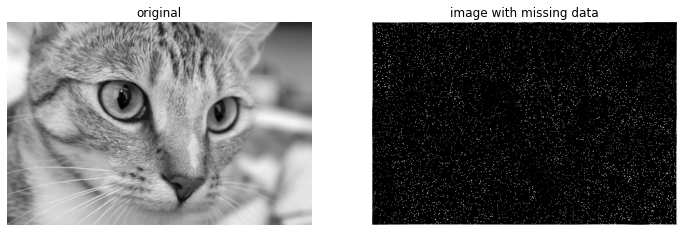

------ Infos ------
Image size (300, 451)
Number of unknowns 127122


In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color
import time
import multiprocessing
import concurrent

# load cat image
original_img = skimage.img_as_float(skimage.color.rgb2gray(skimage.data.chelsea()))

# Create a random mask
RATIO_OF_ZERO = 0.95 # percentage of zero
mask_img = np.random.rand(original_img.shape[0], original_img.shape[1])
mask_img[mask_img > RATIO_OF_ZERO] = 1.0
mask_img[mask_img <= RATIO_OF_ZERO] = 0.0
# Set boundary to 1 to avoid condition when evaluating stencils
mask_img[0,:] = 1.0 # top row
mask_img[-1,:] = 1.0 # bottom row
mask_img[:,0] = 1.0 # left column
mask_img[:,-1] = 1.0 # right column
# Compute the unknown indices 
unknown_indices = np.argwhere(mask_img == 0)
unknown_i = unknown_indices[:,0]
unknown_j = unknown_indices[:,1]
# Compute altered image
altered_img = original_img * mask_img

# Draw original and missing data image
plt.set_cmap('gray')
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(original_img)
axs[0].set_title('original')
axs[0].axis('off')
axs[1].imshow(altered_img)
axs[1].set_title('image with missing data')
axs[1].axis('off')
plt.show()
print('------ Infos ------')
print('Image size {}'.format(original_img.shape))
print('Number of unknowns {}'.format(len(unknown_indices)))

Laplace inpainting solve a linear system $Ax=b$, where A contains the coefficient of the discrete laplace operator and $x$ are the unknwon pixel. The vector $b$ is a zero vector.

Solving this system with jacobi method result in a simple stencil algorithm.

<Figure size 432x288 with 0 Axes>

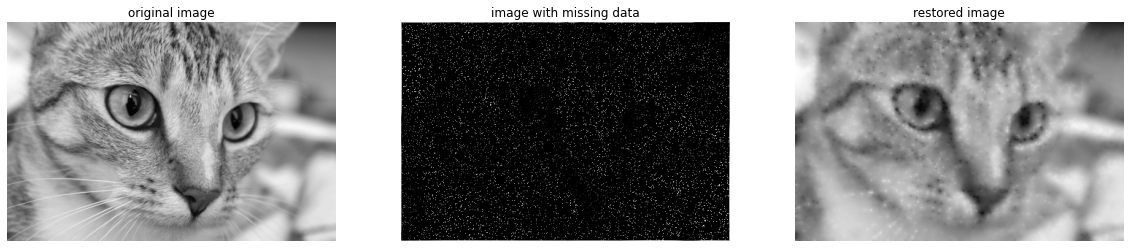

In [3]:
@numba.njit(inline='always', nogil=True)
def stencil_code(x, next_x, i, j):
    next_x[i][j] = (x[i-1][j] + x[i+1][j] + x[i][j-1] + x[i][j+1]) * 0.25

#@numba.njit
def jacobi_iteration(x, next_x, unknown_i, unknown_j):
    for i in numba.prange(len(unknown_i)):
        stencil_code(x, next_x, unknown_i[i], unknown_j[i])

#@numba.njit
def jacobi_solver(unknown_i, unknown_j, img, num_iterations, iteration_op):
    buffer = [np.copy(img), np.copy(img)]
    for iteration in range(num_iterations):
        iteration_op(buffer[0], buffer[1], unknown_i, unknown_j)
        buffer[0], buffer[1] = buffer[1], buffer[0] # swap buffers
    return buffer[0]

# Use jacobi solver
jacobi_iteration_njit = numba.njit(jacobi_iteration)
jacobi_solver_njit = numba.njit(jacobi_solver)
restored_img = jacobi_solver_njit(unknown_i, unknown_j, altered_img, 200, jacobi_iteration_njit)

# Draw original, missing data and restored image
def show_result(result_img, restore_title='restored image'):
    plt.set_cmap('gray')
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(original_img)
    axs[0].set_title('original image')
    axs[0].axis('off')
    axs[1].imshow(altered_img)
    axs[1].set_title('image with missing data')
    axs[1].axis('off')
    axs[2].imshow(result_img)
    axs[2].set_title(restore_title)
    axs[2].axis('off')
show_result(restored_img)

## Benchmark

*   Vanilla Python
*   Numba CPU
*   Numba CPU multithreaded (with python)
*   Numba GPU

### Vanilla Python

Vanilla Python (20 iterations) : 2.755 sec


<Figure size 432x288 with 0 Axes>

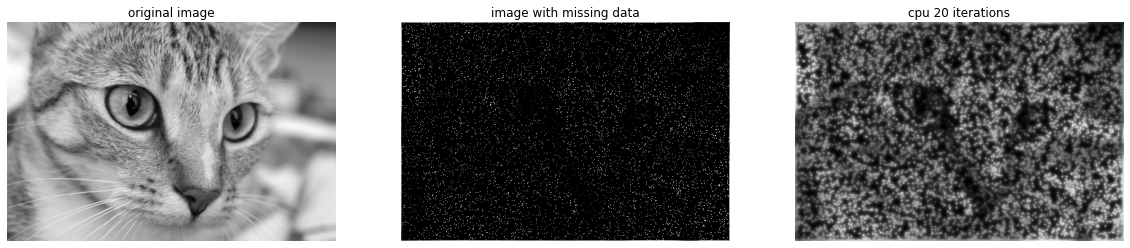

In [4]:
start_time = time.time()
restored_img = jacobi_solver(unknown_i, unknown_j, altered_img, 20, jacobi_iteration)
print('Vanilla Python (20 iterations) : %2.3f sec' % (time.time() - start_time))
show_result(restored_img, 'cpu 20 iterations')

### Numba CPU

Numba CPU (2000 iterations) : 2.588 sec


<Figure size 432x288 with 0 Axes>

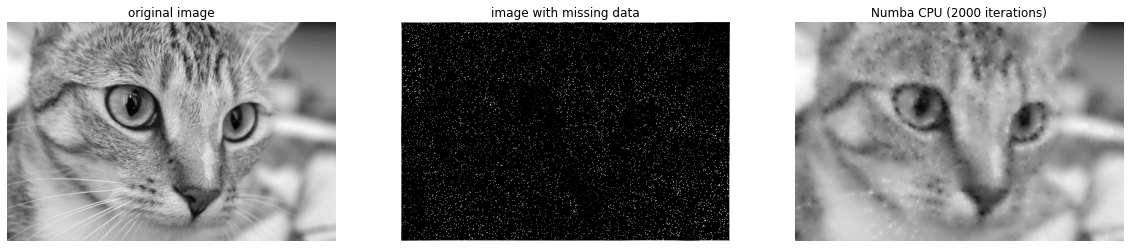

In [8]:
start_time = time.time()
jacobi_iteration_njit = numba.njit(jacobi_iteration)
jacobi_solver_njit = numba.njit(jacobi_solver)
restored_img = jacobi_solver_njit(unknown_i, unknown_j, altered_img, 2000, jacobi_iteration_njit)
print('Numba CPU (2000 iterations) : %2.3f sec' % (time.time() - start_time))
show_result(restored_img, 'Numba CPU (2000 iterations)')

### Numba CPU MT with Numba

Numba CPU (2000 iterations) 2.680 sec


<Figure size 432x288 with 0 Axes>

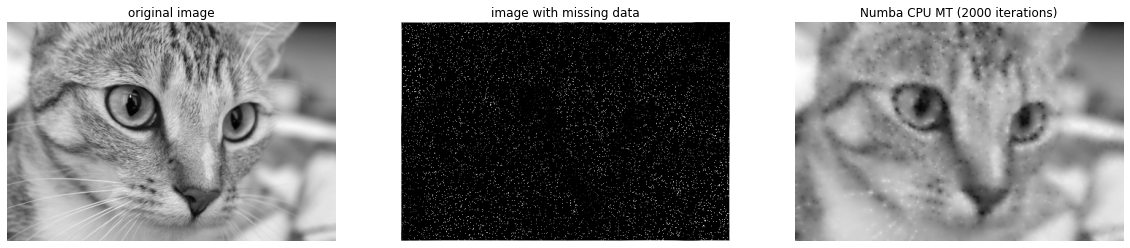

In [6]:
# NumbaWarning: The TBB threading layer requires TBB version 2019.5 
#!pip install --upgrade tbb
numba.config.THREADING_LAYER = 'omp'

jacobi_iteration_njit = numba.njit(jacobi_iteration, parallel=True)
jacobi_solver_njit = numba.njit(jacobi_solver)
start_time = time.time()
restored_img = jacobi_solver_njit(unknown_i, unknown_j, altered_img, 2000, jacobi_iteration_njit)
print('Numba CPU (2000 iterations) %2.3f sec' % (time.time() - start_time))
show_result(restored_img, 'Numba CPU MT (2000 iterations)')

### Numba CPU MT with ThreadPoolExecutor

Numba CPU with ThreadPoolExecutor  2.406 sec


<Figure size 432x288 with 0 Axes>

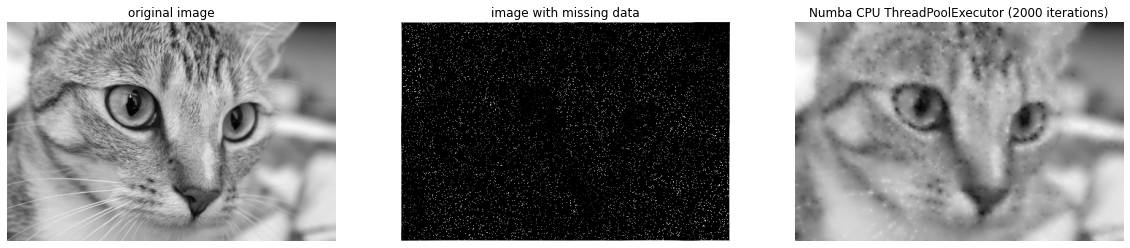

In [7]:
from concurrent.futures import ThreadPoolExecutor

def jacobi_solver_mt(unknown_indices, img, num_iterations, max_threads):
    jacobi_iteration_njit = numba.njit(jacobi_iteration, nogil=True)

    buffer = [np.copy(img), np.copy(img)]
    # split unknow indices into max_thread subarrays of almost equal sizes 
    sub_unknown_indices = np.array_split(unknown_indices, max_threads)

    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        for iteration in range(num_iterations):
            futures = []
            for thread_id in range(max_threads):
                unknown_i = sub_unknown_indices[thread_id][:,0]
                unknown_j = sub_unknown_indices[thread_id][:,1]
                f = executor.submit(jacobi_iteration_njit, 
                                    buffer[0], buffer[1], 
                                    unknown_i, unknown_j)
                futures.append(f)
            concurrent.futures.wait(futures)
            buffer[0], buffer[1] = buffer[1], buffer[0] # swap buffers
    return buffer[0]

start_time = time.time()
restored_img = jacobi_solver_mt(unknown_indices, altered_img, 2000, 2)
print('Numba CPU with ThreadPoolExecutor  %2.3f sec' % (time.time() - start_time))
show_result(restored_img, 'Numba CPU ThreadPoolExecutor (2000 iterations)')

### Numba GPU - Simple version

threads per block (16, 16)
blocks per grid (19, 29)


<Figure size 432x288 with 0 Axes>

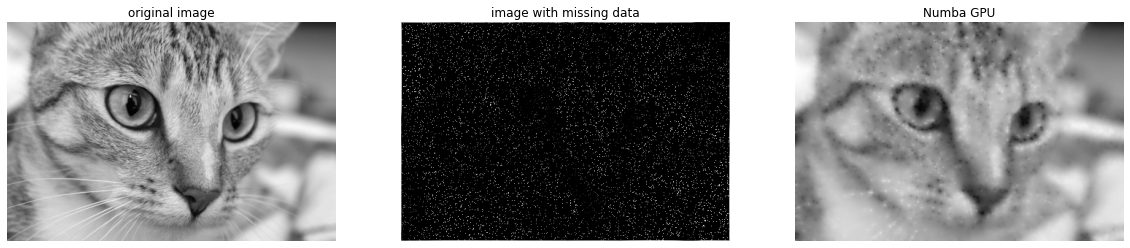

In [19]:
from numba import cuda
import math

@numba.njit 
def stencil_code(img, i, j):
    return (img[i-1,j] + img[i+1,j] + img[i,j-1] + img[i,j+1]) * 0.25

@cuda.jit
def jacobi_solver_cuda(img, mask):
    # QUESTION : Race condition ? 
    i, j = cuda.grid(2) # cuda.grid() gives the absolute position
    if mask[i,j]!=0.0:
        return

    if i < img.shape[0]-1 and j < img.shape[1]-1 and i > 0 and j > 0:
        # Ok 
        #img[i,j] = (img[i-1,j] + img[i+1,j] + img[i,j-1] + img[i,j+1]) * 0.25
        # That is cooler (call njit) !
        img[i,j] = stencil_code(img, i, j)

gpu_altered_img = np.copy(altered_img)
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(gpu_altered_img.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(gpu_altered_img.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
for i in range(1000):
    jacobi_solver_cuda[blockspergrid, threadsperblock](gpu_altered_img, mask_img)
show_result(gpu_altered_img, 'Numba GPU')
print('threads per block', threadsperblock)
print('blocks per grid', blockspergrid)

## Random Tips and Tricks

#### Pass multiple arrays to Numba

In [13]:
def test_multiple_numpy_array(images):
    print('valid')

array1 = altered_img[0:50,:]
array2 = altered_img
print('test python tuple')
test_multiple_numpy_array((array1, array2))
print('test numba.typed.List')
test_multiple_numpy_array(numba.typed.List([array1, array2]))

test python tuple
valid
test numba.typed.List
valid


#### Recompilation

In [ ]:
test_multiple_numpy_array.recompile()

#### Inspect Function

In [ ]:
print(test_multiple_numpy_array.inspect_types())

test_multiple_numpy_array (UniTuple(array(float64, 2d, C) x 2),)
--------------------------------------------------------------------------------
# File: <ipython-input-42-4ce2456ea3a7>
# --- LINE 1 --- 

@numba.njit

# --- LINE 2 --- 

def test_multiple_numpy_array(images):

    # --- LINE 3 --- 
    # label 0
    #   images = arg(0, name=images)  :: UniTuple(array(float64, 2d, C) x 2)
    #   del images
    #   $2load_global.0 = global(print: <built-in function print>)  :: Function(<built-in function print>)
    #   del $2load_global.0
    #   $const4.1 = const(str, valid)  :: Literal[str](valid)
    #   print($const4.1)
    #   del $const4.1
    #   $6call_function.2 = const(NoneType, None)  :: none
    #   del $6call_function.2
    #   $const10.3 = const(NoneType, None)  :: none
    #   $12return_value.4 = cast(value=$const10.3)  :: none
    #   del $const10.3
    #   return $12return_value.4

    print('valid')


test_multiple_numpy_array (ListType[array(float64, 2d, C)],)
-------